Load config and dependencies

In [1]:
from importlib import reload

from src.data import make_dataset

from src.models import config
config = reload(config)
from src.models.unet import UNet
from src.models.train_model import Trainer

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch

import albumentations as A

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Load train images
trainImages = config.train_orange_3_doors_images + config.train_black_5_doors_images

# Split images into train and val
train_dataset, val_dataset = random_split(trainImages, [1-config.VAL_SPLIT,config.VAL_SPLIT])
print(f"Dataset length: {len(trainImages)}")
print(f"Validation length: {len(val_dataset)}")
print(f"Train length: {len(train_dataset)}")

Dataset length: 2833
Validation length: 424
Train length: 2409


unique values in class channel of:
[ 0 10 20 30 40 50 60 70 80 90]
1



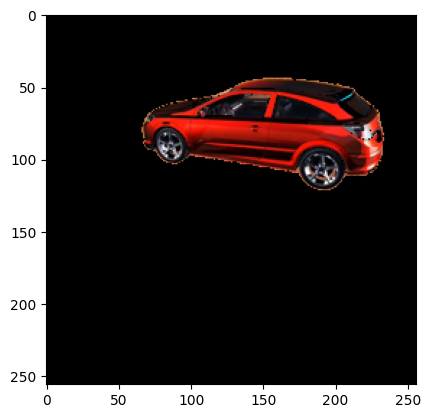

In [3]:
import numpy as np
import cv2

arrayz = np.load(trainImages[100])
print('unique values in class channel of:', np.unique(arrayz[:, :, 3]), sep='\n')
image = arrayz[:,:,:3]
mask = arrayz[:,:,3]

mask2 = np.where((mask==0),0,1).astype('bool')

background = cv2.imread(config.background_images[1])
background = cv2.resize(background,(config.INPUT_IMAGE_WIDTH,config.INPUT_IMAGE_HEIGHT))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
mask2=mask2[:,:,np.newaxis]
img = (image * mask2)

print(np.random.randint(1, 3))

print()
plt.imshow(img)
plt.show()

In [4]:
# define transformations
testTransform = A.Compose(
    [A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
     #A.ToGray(p=1)
    ]
)

ShiftDic = {
    'y' : (0.3,0.5)
}

trainTransform = A.Compose(
    [
        A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
        A.RandomBrightnessContrast(brightness_limit=(0,0.10), contrast_limit=0.10, p=0.5),
        A.ChannelShuffle(p=0.5),
        A.Affine(translate_percent=ShiftDic,always_apply=True),
        A.Affine(scale=(0.7,1), rotate=(-25,25), shear=0, p=0.5),
    ]
)

# create the train and val datasets
train_DS = make_dataset.imageArrayDataset(arrayPaths=train_dataset, 
                                          bgPaths=config.background_images, 
                                          transforms=trainTransform)

val_DS = make_dataset.imageArrayDataset(arrayPaths=val_dataset,
                                        bgPaths=config.background_images, 
                                        transforms=testTransform)

test_DS = make_dataset.imageArrayDataset(arrayPaths=config.test_images,
                                         bgPaths=config.background_images, 
                                         transforms=testTransform, 
                                         test=True)

# create the training and val data loaders
trainLoader = DataLoader(train_DS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
valLoader = DataLoader(val_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
testLoader = DataLoader(test_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)


torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


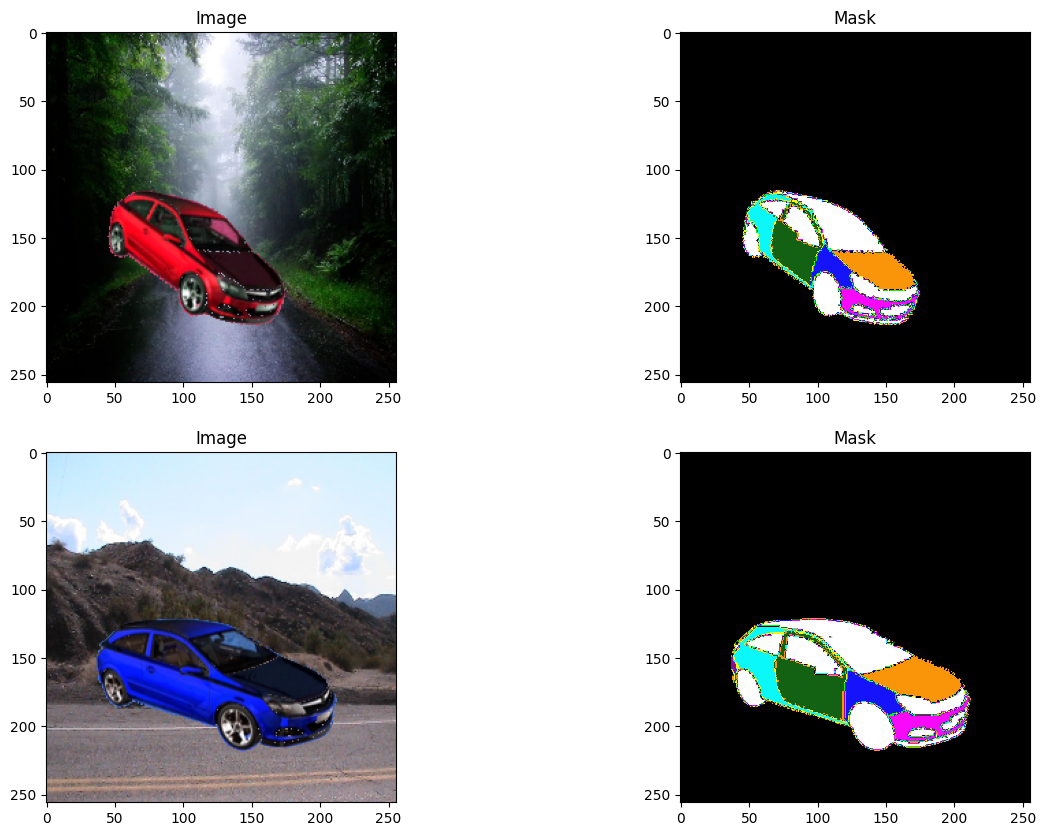

In [5]:
imageLoad, maskLoad = next(iter(trainLoader))
imageLoad, maskLoad = imageLoad.to(config.DEVICE), maskLoad.to(config.DEVICE)

print(imageLoad.shape, maskLoad.shape, type(imageLoad), type(maskLoad), imageLoad.dtype, maskLoad.dtype)
print(torch.unique(maskLoad))

colors_info = {
    0:  (0,0,0),            # background to black
    10: (250, 149, 10),     # orange
    20: (19, 98, 19),       # dark green
    30: (249, 249, 10),     # yellow
    40: (10, 248, 250),     # cyan
    50: (149, 7, 149),      # purple
    60: (5, 249, 9),        # light green
    70: (20, 19, 249),      # blue
    80: (249, 9, 250),      # pink
    90: 'white'              # no color (NA)
}
# Convert RGB values to floats between 0 and 1
colors_info = {key: value if isinstance(value, str) else (value[0] / 255, value[1] / 255, value[2] / 255) for key, value in colors_info.items()}
# Create a custom colormap
carseg_cmap = ListedColormap(colors_info.values(), name="custom_cmap")

test_batch_size=2
fig, axes = plt.subplots(test_batch_size, 2, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):

    image = imageLoad[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = maskLoad[i].cpu().detach().numpy()

    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(label_class,cmap=carseg_cmap)
    axes[i, 1].set_title("Mask")

    

In [6]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from src.models import deeplab
deeplab = reload(deeplab)

In [7]:
# initialize our UNet model
# Model = UNet().to(config.DEVICE)
Model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)

# initialize loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = smp.losses.FocalLoss(mode="multiclass")

opt = Adam(Model.parameters(), lr=0.1e-4)

# Train model
trainer = Trainer(
    model=Model, 
    criterion=criterion,
    optimizer=opt,
    device=config.DEVICE
)

trainer.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=10,
    patience=2)

torch.save(Model, "Models/model_v1.pth")

Starting Training...


Epoch 1: 100%|██████████| 151/151 [01:02<00:00,  2.40batch/s, loss=1.27]
INFO:root:Epoch 1/10 | Train loss: 1.2720556259155273 | Validation loss: 1.3430856466293335 | Time/epoch: 77.03283 seconds
Epoch 2: 100%|██████████| 151/151 [01:06<00:00,  2.26batch/s, loss=0.897]
INFO:root:Epoch 2/10 | Train loss: 0.8965898752212524 | Validation loss: 1.0148199796676636 | Time/epoch: 81.48207 seconds
Epoch 3: 100%|██████████| 151/151 [01:02<00:00,  2.43batch/s, loss=0.681]
INFO:root:Epoch 3/10 | Train loss: 0.6808883547782898 | Validation loss: 0.7808144092559814 | Time/epoch: 76.60697 seconds
Epoch 4: 100%|██████████| 151/151 [01:01<00:00,  2.45batch/s, loss=0.55] 
INFO:root:Epoch 4/10 | Train loss: 0.5503667593002319 | Validation loss: 0.631488025188446 | Time/epoch: 76.28547 seconds
Epoch 5:  95%|█████████▍| 143/151 [00:58<00:02,  3.05batch/s, loss=0.455]

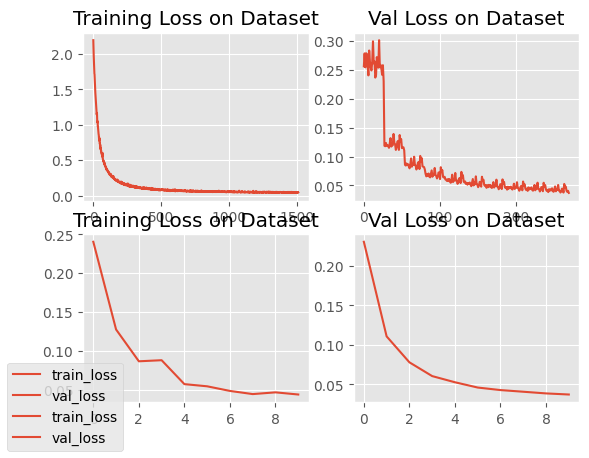

In [ ]:
# plot the training loss
fig, axes = plt.subplots(2, 2)
plt.style.use("ggplot")
axes[0,0].plot(trainer.train_step_loss, label="train_loss")
axes[0,1].plot(trainer.val_step_loss, label="val_loss")
axes[0,0].set_title("Training Loss on Dataset")
axes[0,1].set_title("Val Loss on Dataset")

axes[1,0].plot(trainer.train_loss_, label="train_loss")
axes[1,1].plot(trainer.val_loss_, label="val_loss")
axes[1,0].set_title("Training Loss on Dataset")
axes[1,1].set_title("Val Loss on Dataset")

fig.legend(loc="lower left")


In [ ]:
# import pickle

# with open("train_step_loss", "wb") as fp:   #Pickling
#         pickle.dump(trainer.train_step_loss, fp)

# with open("val_step_loss", "wb") as fp:   #Pickling
#         pickle.dump(trainer.val_step_loss, fp)

# with open("train_loss_", "wb") as fp:   #Pickling
#         pickle.dump(trainer.train_loss_, fp)

# with open("val_loss_", "wb") as fp:   #Pickling
#         pickle.dump(trainer.val_loss_, fp)

In [14]:
X, Y = next(iter(testLoader))
X, Y = X.to(config.DEVICE), Y.to(config.DEVICE)
Y_pred = Model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)
print(torch.unique(Y_pred))

torch.Size([16, 10, 256, 256])
torch.Size([16, 256, 256])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [17]:
tp, fp, fn, tn = smp.metrics.get_stats(Y_pred, Y, mode="multiclass",num_classes=10)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
print(iou_score)

tensor(0.5484)


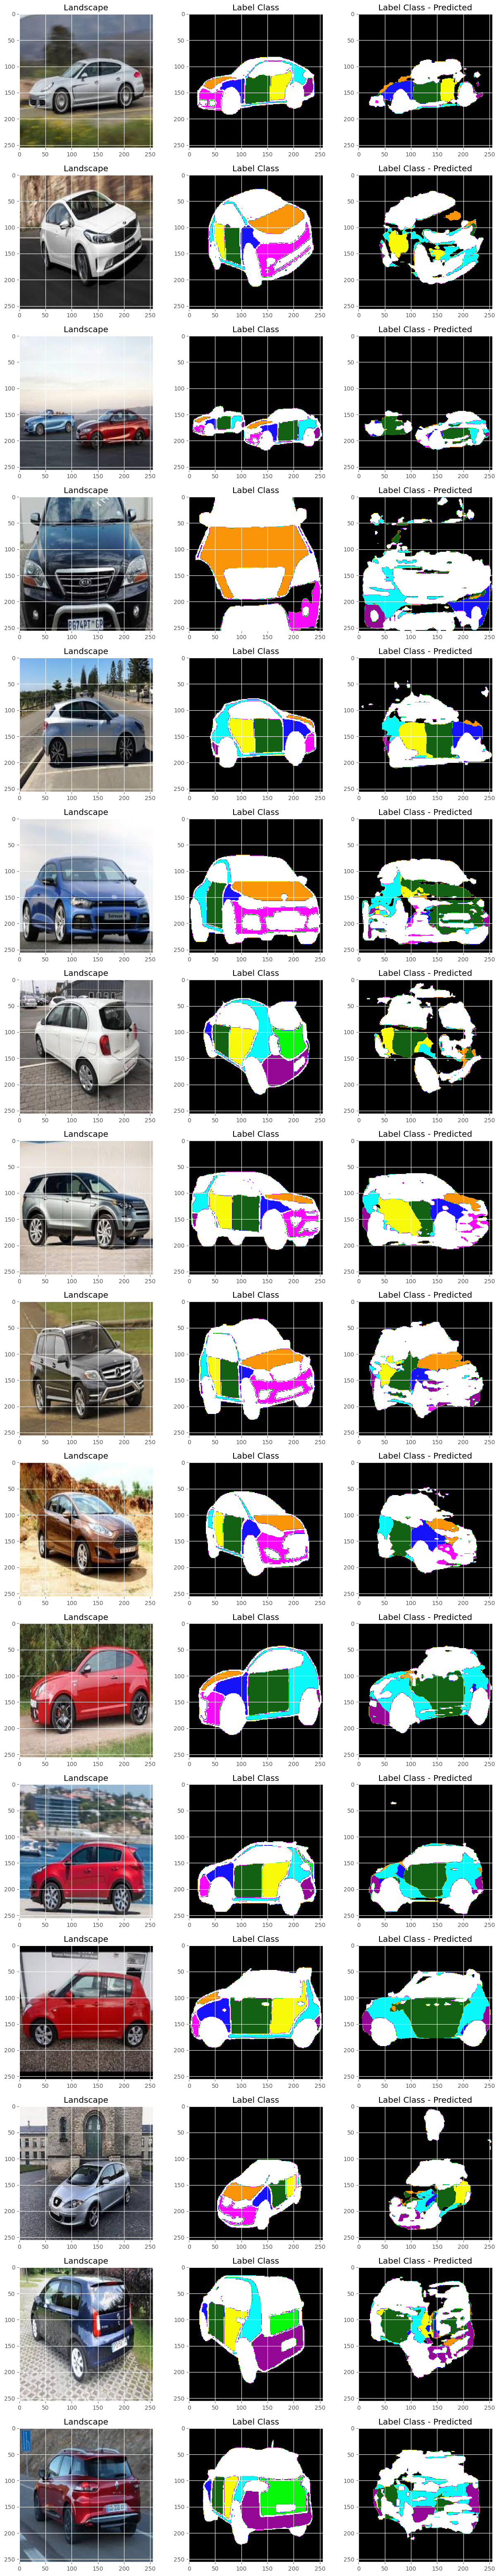

In [ ]:
test_batch_size=16
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))


for i in range(test_batch_size):

    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class,cmap=carseg_cmap)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted,cmap=carseg_cmap)
    axes[i, 2].set_title("Label Class - Predicted")